<a href="https://colab.research.google.com/github/hemantnyadav/deepar_gluonts/blob/main/GluonTS_DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!pip install gluonts
#!pip install mxnet==1.6.0

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/My Drive/"

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gluonts.mx import DeepAREstimator, Trainer

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [7]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [10]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

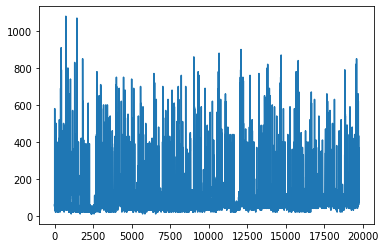

In [10]:
df['Appliances'].plot()

In [11]:
df.shape

(19735, 29)

In [13]:
df_input = df[['date', 'Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint']]
df_input  = df_input.set_index('date')
df_input.head()

,Appliances,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
date,,,,,,,
2016-01-11 17:00:00,60,6.600000,733.5,92.0,7.000000,63.000000,5.3
2016-01-11 17:10:00,60,6.483333,733.6,92.0,6.666667,59.166667,5.2
2016-01-11 17:20:00,50,6.366667,733.7,92.0,6.333333,55.333333,5.1
2016-01-11 17:30:00,50,6.250000,733.8,92.0,6.000000,51.500000,5.0
2016-01-11 17:40:00,60,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [14]:
prediction_length = 144 #  Predicting next day: As observations are evry 10 min 
                        #  so in hour total 6 observation and in a day 144
train_time = "2016-05-10 00:00:00"

In [16]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [
        {"start":df_input.index[0], "target":df_input.Appliances[:train_time]}
    ],
    freq = "10min"
)

In [17]:
training_data

[{'start': Period('2016-01-11 17:00', '10T'),
  'target': array([60., 60., 50., ..., 50., 70., 50.], dtype=float32)}]

In [20]:
estimator = DeepAREstimator( freq = "10min",
                            context_length = 720,
                            prediction_length = prediction_length,
                            num_layers= 2,
                            num_cells= 12,
                            cell_type='lstm',
                            trainer = Trainer(epochs=8)
                            )

predictor = estimator.train(training_data = training_data)

100%|██████████| 50/50 [00:58<00:00,  1.17s/it, epoch=8/8, avg_epoch_loss=4.56]


In [21]:
test_data = ListDataset(
    [
        {"start":df_input.index[0], "target":df_input.Appliances[:"2016-05-11 00:00:00"]},
        {"start":df_input.index[0], "target":df_input.Appliances[:"2016-05-15 00:00:00"]}
    ],
    freq = "10min"
)

In [22]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [23]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor = predictor,
    num_samples=100
)

In [24]:
forecasts = list(forecast_it)
tss = list(ts_it)
forecast_entry=  forecasts[0]
ts_entry = tss[0]
forecast_entry


gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[50.908924  , 56.995625  , 48.972935  , ...,  4.8589597 ,
         0.20919223, 27.349241  ],
       [61.799175  , 56.41518   , 75.192     , ..., 50.31325   ,
        36.894756  , 50.222168  ],
       [60.266346  , 63.397007  , 69.66625   , ..., 51.197712  ,
        51.9902    , 44.38025   ],
       ...,
       [51.17405   , 37.285088  , 46.6864    , ..., 55.066357  ,
        54.702362  , 56.37491   ],
       [76.53599   , 70.321915  , 64.146835  , ..., 56.384384  ,
        59.51774   , 63.00092   ],
       [62.776474  , 75.79685   , 55.622337  , ..., 63.020798  ,
        70.83252   , 58.72729   ]], dtype=float32), start_date=Period('2016-05-10 00:10', '10T'))

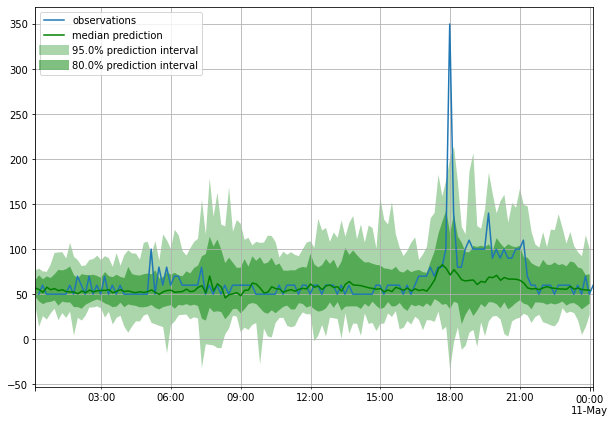

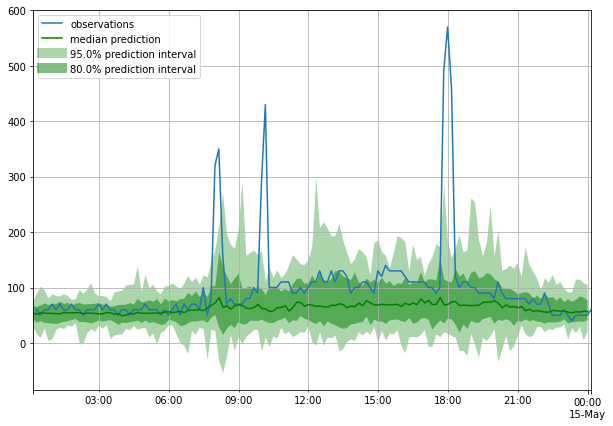

In [25]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])
plot_prob_forecasts(tss[1], forecasts[1])

In [26]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1,0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)


Running evaluation: 2it [00:00, 32.90it/s]


In [28]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2016-05-10 00:10,733.383518,1863.985229,9510.0,66.041667,64.962137,0.199260,0.155516,0.172129,0.196003,2.289430,851.455983,0.0,1863.985241,0.368056,1221.482585,0.916667
1,None,2016-05-14 00:10,6911.177083,5543.736328,14350.0,99.652778,64.259270,0.599107,0.264871,0.333520,0.386323,9.064989,1791.082752,0.0,5543.736309,0.118056,4781.489371,0.750000
